In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import zscore
from scipy.stats import skew, kurtosis
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.sandbox.regression.gmm import GMM

## Part 1

In [89]:
data = pd.read_csv('/Users/mahinbindra/Downloads/midterm_partone.csv')

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1696 entries, 0 to 1695
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Constant            1696 non-null   int64  
 1   Stock Change        1696 non-null   float64
 2   Inventory Turnover  1696 non-null   float64
 3   Operating Profit    1696 non-null   float64
 4   Interaction Effect  1696 non-null   float64
 5   Current Ratio       1696 non-null   float64
 6   Quick Ratio         1696 non-null   float64
 7   Debt Asset Ratio    1696 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 106.1 KB


In [91]:
data.describe(include='all')

,Constant,Stock Change,Inventory Turnover,Operating Profit,Interaction Effect,Current Ratio,Quick Ratio,Debt Asset Ratio
count,1696.0,1696.000000,1696.000000,1696.000000,1696.000000,1696.000000,1696.000000,1696.000000
mean,1.0,-0.012977,24.633183,0.255719,6.584336,1.972308,1.069610,0.150254
std,0.0,0.490888,37.044608,0.590330,42.544580,1.509598,1.161417,0.275665
min,1.0,-2.366261,0.996475,-5.989709,-411.751139,0.202040,0.035457,0.000000
25%,1.0,-0.258291,3.733259,0.151177,0.646555,1.079045,0.366561,0.000000
50%,1.0,-0.005839,6.372805,0.244090,1.596459,1.585408,0.694119,0.037937
75%,1.0,0.234015,29.433657,0.338010,5.298054,2.364317,1.258383,0.236709
max,1.0,4.138063,240.046041,7.450718,884.467955,13.026268,10.501619,3.675735


In [92]:
data.head()

,Constant,Stock Change,Inventory Turnover,Operating Profit,Interaction Effect,Current Ratio,Quick Ratio,Debt Asset Ratio
0,1,0.870332,1.795946,0.115846,0.208053,1.672527,0.255171,0.473317
1,1,-0.047347,1.395501,0.436967,0.609788,1.637261,0.221763,0.489967
2,1,0.001176,1.664563,0.541016,0.900555,1.640619,0.189141,0.374269
3,1,-0.901200,1.605738,0.539399,0.866133,1.436221,0.131944,0.224399
4,1,-0.176353,1.591451,0.539938,0.859285,1.433140,0.183095,0.213446


In [93]:
model_iv = sm.OLS(data["Inventory Turnover"],data[["Constant","Current Ratio","Quick Ratio",\
                                                                 "Debt Asset Ratio"]]).fit()
endog_predict = model_iv.predict(data[["Constant","Current Ratio","Quick Ratio","Debt Asset Ratio"]])
data["Endogenous Param"] = endog_predict

In [95]:
model_2sls = sm.OLS(data["Stock Change"], data[["Constant","Endogenous Param",\
                                                              "Operating Profit","Interaction Effect",\
                                                             ]]).fit()
model_2sls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Stock Change   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     8.530
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           1.27e-05
Time:                        15:05:43   Log-Likelihood:                -1186.5
No. Observations:                1696   AIC:                             2381.
Df Residuals:                    1692   BIC:                             2403.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Constant              -0.0176      0.020     -0.896      0.370      -0.056       0.021
Endogenous Param       0.0011      0.001      1.827      0.068   -7.76e-05       0.002
Operating Profit      -0.1201      0.028     -4.319      0.000      -0.175      -0.066
Interaction Effect     0.0014      0.000      3.621      0.000       0.001       0.002
==============================================================================
Omnibus:                      368.832   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3433.920
Skew:                           0.742   Prob(JB):                         0.00
Kurtosis:                       9.811   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Part 1.1

In [98]:
y_vals  = np.array(data["Stock Change"])
x_vals  = np.array(data[["Inventory Turnover","Operating Profit","Interaction Effect"]])
iv_vals = np.array(data[["Current Ratio","Quick Ratio","Debt Asset Ratio"]])

class final_gmm(GMM):
    def momcond(self, params):
        p0, p1, p2, p3, delta = params
        endog = self.endog
        exog = self.exog
        inst = self.instrument   
        
        errors = endog - (p0 + p1 * exog[:,0] + p2 * exog[:,1] + p3 * exog[:,2])
        ones_vector = np.ones((errors.shape[0], 3))  # Vector of three ones for each observation
        moment0 = errors - delta * ones_vector[:, 0]
        moment1 = errors * exog[:,0] - delta * ones_vector[:, 1]
        moment2 = errors * exog[:,1] - delta * ones_vector[:, 1]
        moment3 = errors * exog[:,2] - delta * ones_vector[:, 1]
        moment4 = errors * inst[:,0] - delta * ones_vector[:, 2]
        moment5 = errors * inst[:,1] - delta * ones_vector[:, 2]
        moment6 = errors * inst[:,2] - delta * ones_vector[:, 2]
        g = np.column_stack((moment0, moment1, moment2, moment3, moment4, moment5, moment6))
        return g

beta0_updated = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
final_res = final_gmm(endog=y_vals, exog=x_vals, instrument=iv_vals, k_moms=7, k_params=5).fit(beta0_updated)
final_res.summary()

Optimization terminated successfully.
         Current function value: 0.000077
         Iterations: 14
         Function evaluations: 18
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.001305
         Iterations: 8
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.001294
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.001294
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                              final_gmm Results                               
==============================================================================
Dep. Variable:                      y   Hansen J:                        2.194
Model:                      final_gmm   Prob (Hansen J):                 0.334
Method:                           GMM                                         
Date:                Fri, 10 Nov 2023                                         
Time:                        15:13:42                                         
No. Observations:                1696                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p 0           -0.0013      0.017     -0.077      0.939      -0.034       0.032
p 1            0.0003      0.000      0.963      0.335      -0.000       0.001
p 2           -0.1312      0.034     -3.860      0.000      -0.198      -0.065
p 3            0.0015      0.000      3.679      0.000       0.001       0.002
p 4            0.0025      0.003      0.883      0.377      -0.003       0.008
==============================================================================
"""

### Part 1.2

**Interpretation:**
Delta Term (p4): The coefficient of the delta term is 0.0025 with a p-value of 0.377. This p-value indicates that the delta term is not statistically significant at conventional levels (typically p < 0.05). Thus, there is not enough statistical evidence to reject the null hypothesis that the delta term is zero, and consequently, it does not support the expert's claim of a non-zero bias in the moment conditions.

Other Coefficients: While the delta term is not significant, the 'Operating Profit' and 'Interaction Effect' variables are both significant, as indicated by their low p-values. This suggests that these variables do have a significant effect on the stock change.

Model Fit and Instrument Validity: The Hansen J statistic has a p-value of 0.334, which is sufficiently large to suggest that the overidentifying restrictions are not violated and that the model's instruments are valid.

**Conclusion:**
The examination of the Generalized Method of Moments (GMM) models, both before and after the incorporation of the proposed delta term, reveals that there is no statistical evidence to support the industry expert's claim of a non-zero bias in the moment conditions of instrumental variables. Specifically, the inclusion of the delta term in the model did not yield a statistically significant coefficient, indicating that the bias is either nonexistent or undetectable with the current dataset and model specification. Furthermore, while the delta term's inclusion does alter the estimates and standard errors of other model parameters, these changes do not substantiate the claim of bias. The Hansen J statistic suggests that the model's instruments remain valid after accounting for the delta term. In summary, based on the GMM summary table and test statistics of coefficients, the expert's claim is not justified within the confines of the provided data and the specified econometric model.

## Part 2

In [33]:
df = pd.read_csv('/Users/mahinbindra/Downloads/midterm_parttwo.csv')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8081 entries, 0 to 8080
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Years of Education after High School  8081 non-null   int64 
 1   Requested Credit Amount               8081 non-null   object
 2   Number of Dependents                  8081 non-null   object
 3   Monthly Income                        8081 non-null   object
 4   Monthly Expense                       8081 non-null   object
 5   Marital Status                        8081 non-null   object
 6   Credit Rating                         8081 non-null   object
dtypes: int64(1), object(6)
memory usage: 442.1+ KB


In [35]:
df.describe(include='all')

,Years of Education after High School,Requested Credit Amount,Number of Dependents,Monthly Income,Monthly Expense,Marital Status,Credit Rating
count,8081.000000,8081,8081,8081,8081,8081,8081
unique,NaN,3,3,5,5,3,2
top,NaN,Low,Less than 2,Very low,Very low,Married,Positive
freq,NaN,5442,3616,3183,6243,5876,6935
mean,2.608588,NaN,NaN,NaN,NaN,NaN,NaN
std,1.571835,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df.head()

,Years of Education after High School,Requested Credit Amount,Number of Dependents,Monthly Income,Monthly Expense,Marital Status,Credit Rating
0,1,Low,No dependent,Very low,Very low,Married,Positive
1,2,Low,No dependent,Very low,Very low,Single,Positive
2,1,Low,No dependent,Very low,Very low,Single,Positive
3,3,Low,No dependent,Very low,Very low,Married,Positive
4,3,Low,No dependent,Very low,Very low,Single,Negative


In [37]:
df['ID'] = range(1, len(df)+1)
df['ID'].sort_index()

0          1
1          2
2          3
3          4
4          5
        ... 
8076    8077
8077    8078
8078    8079
8079    8080
8080    8081
Name: ID, Length: 8081, dtype: int64

In [38]:
df.groupby(['Credit Rating', 'Years of Education after High School'])['ID'].count().unstack()

Years of Education after High School,0,1,2,3,4,5,6,7
Credit Rating,,,,,,,,
Negative,61,291,211,404,9,135,6,29
Positive,324,1607,1320,2421,95,895,71,202


In [39]:
df.groupby(['Credit Rating', 'Requested Credit Amount'])['ID'].count().unstack()

Requested Credit Amount,High,Low,Medium
Credit Rating,,,
Negative,6,721,419
Positive,66,4721,2148


In [40]:
df.groupby(['Credit Rating', 'Number of Dependents'])['ID'].count().unstack()

Number of Dependents,Less than 2,More than 2,No dependent
Credit Rating,,,
Negative,519,120,507
Positive,3097,738,3100


In [41]:
df.groupby(['Credit Rating', 'Monthly Income'])['ID'].count().unstack()

Monthly Income,High,Low,Moderate,Very High,Very low
Credit Rating,,,,,
Negative,68,434,243,18,383
Positive,427,2401,1177,130,2800


In [42]:
df.groupby(['Credit Rating', 'Monthly Expense'])['ID'].count().unstack()

Monthly Expense,High,Low,Moderate,Very high,Very low
Credit Rating,,,,,
Negative,11,193,41,5,896
Positive,83,1286,195,24,5347


In [43]:
df.groupby(['Credit Rating', 'Marital Status'])['ID'].count().unstack()

Marital Status,Married,Not specified,Single
Credit Rating,,,
Negative,851,19,276
Positive,5025,126,1784


In [44]:
df.columns

Index(['Years of Education after High School', 'Requested Credit Amount',
       'Number of Dependents', 'Monthly Income', 'Monthly Expense',
       'Marital Status', 'Credit Rating', 'ID'],
      dtype='object')

In [60]:
df2 = df.copy()

In [61]:
def credit_rating(x):
    if x =='Positive':
        return 1
    elif x =='Negative':
        return 0

In [62]:
df2['Credit Rating']= df2['Credit Rating'].apply(credit_rating)

In [67]:
df2.head()

,Years of Education after High School,Requested Credit Amount,Number of Dependents,Monthly Income,Monthly Expense,Marital Status,Credit Rating,ID
0,1,Low,No dependent,Very low,Very low,Married,1,1
1,2,Low,No dependent,Very low,Very low,Single,1,2
2,1,Low,No dependent,Very low,Very low,Single,1,3
3,3,Low,No dependent,Very low,Very low,Married,1,4
4,3,Low,No dependent,Very low,Very low,Single,0,5


### Part 2.1

In [68]:
cat_columns = ['Years of Education after High School', 'Requested Credit Amount','Number of Dependents','Monthly Income', 'Monthly Expense', 'Marital Status']
target = 'Credit Rating'

In [69]:
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = StandardScaler()
preprocessor = ColumnTransformer(transformers = [('cat',cat_transformer, cat_columns)])

In [70]:
X_train, X_test, y_train, y_test = train_test_split(df2[cat_columns], df2[target], test_size=0.5, random_state=42)

In [71]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [72]:
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

In [73]:
log_reg = LogisticRegression()

In [74]:
log_fit = log_reg.fit(X_train_transformed, y_train)
log_pred = log_reg.predict(X_test_transformed)

In [76]:
conf_matrix = confusion_matrix(y_test, log_pred)
precision = precision_score(y_test, log_pred)
recall = recall_score(y_test, log_pred)
f1 = f1_score(y_test, log_pred)

In [77]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[   0  577]
 [   0 3464]]


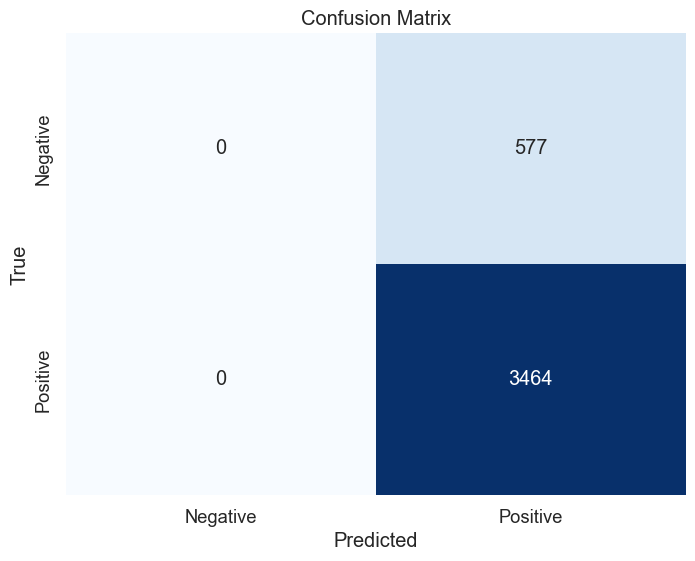

In [78]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [79]:
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.8572135609997525
Recall: 1.0
F1 Score: 0.9231179213857428


In [99]:
conf_matrix = confusion_matrix(y_test, log_pred)

In [103]:
class_report = classification_report(y_test, log_pred)

In [105]:
print(class_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       577
           1       0.86      1.00      0.92      3464

    accuracy                           0.86      4041
   macro avg       0.43      0.50      0.46      4041
weighted avg       0.73      0.86      0.79      4041



### Part 2.2

In [80]:
desired_approval_rate = 0.15
log_reg_probs = log_reg.predict_proba(X_test_transformed)[:, 1]
threshold = np.quantile(log_reg_probs, 1 - desired_approval_rate)

In [81]:
log_reg_pred_thresholded = (log_reg_probs >= threshold).astype(int)

In [82]:
conf_matrix_thresholded = confusion_matrix(y_test, log_reg_pred_thresholded)
precision_thresholded = precision_score(y_test, log_reg_pred_thresholded)
recall_thresholded = recall_score(y_test, log_reg_pred_thresholded)
f1_thresholded = f1_score(y_test, log_reg_pred_thresholded)

In [83]:
print("\nUpdated Confusion Matrix:")
print(conf_matrix_thresholded)


Updated Confusion Matrix:
[[ 502   75]
 [2915  549]]


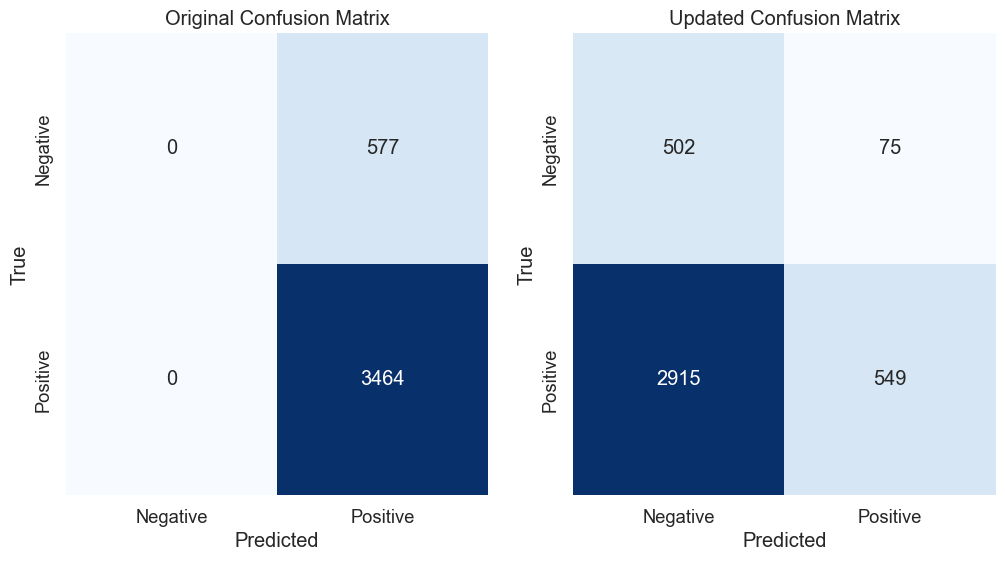

In [84]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Original Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_thresholded, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Updated Confusion Matrix')
plt.show()

In [85]:
print("\nUpdated Precision:", precision_thresholded)
print("Updated Recall:", recall_thresholded)
print("Updated F1 Score:", f1_thresholded)


Updated Precision: 0.8798076923076923
Updated Recall: 0.15848729792147806
Updated F1 Score: 0.26859099804305286


In [106]:
conf_matrix_threhold = confusion_matrix(y_test, log_reg_pred_thresholded)
class_report_threshold = classification_report(y_test, log_reg_pred_thresholded)
print(class_report_threshold)

              precision    recall  f1-score   support

           0       0.15      0.87      0.25       577
           1       0.88      0.16      0.27      3464

    accuracy                           0.26      4041
   macro avg       0.51      0.51      0.26      4041
weighted avg       0.78      0.26      0.27      4041



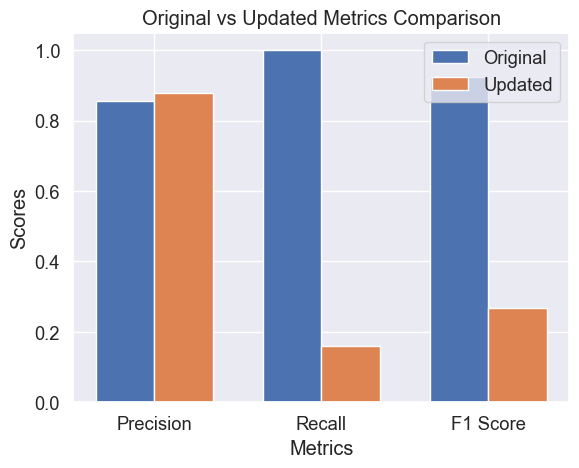

In [86]:
# Original metrics
original_metrics = [precision, recall, f1]

# Updated metrics
updated_metrics = [precision_thresholded, recall_thresholded, f1_thresholded]

# Labels
labels = ['Precision', 'Recall', 'F1 Score']

# Bar width
bar_width = 0.35

# Indices for positioning bars
indices = np.arange(len(labels))

# Create bar plots
plt.bar(indices, original_metrics, bar_width, label='Original')
plt.bar(indices + bar_width, updated_metrics, bar_width, label='Updated')

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Original vs Updated Metrics Comparison')
plt.xticks(indices + bar_width / 2, labels)
plt.legend()

# Show the plot
plt.show()